# Cyclic Voltammetry Simulation with DOLFINx

This notebook demonstrates a cyclic voltammetry (CV) simulation using DOLFINx with:
- Butler-Volmer kinetics at the electrode surface
- Diffusion-only transport in the electrolyte

## Problem Setup

We simulate a simple redox reaction:
$$O + e^- \leftrightarrow R$$

where O is the oxidized species and R is the reduced species.

## Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

# DOLFINx imports
from dolfinx import fem, mesh, default_scalar_type
from dolfinx.fem import petsc
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from mpi4py import MPI
import ufl
from ufl import dx, grad, inner, TestFunction, exp
from petsc4py import PETSc

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## Define Physical Parameters

In [2]:
# Physical parameters
D_O = 1e-9  # Diffusion coefficient of O species (m^2/s)
D_R = 1e-9  # Diffusion coefficient of R species (m^2/s)
C_O_bulk = 1.0  # Bulk concentration of O (mol/m^3 or mM)
C_R_bulk = 1.0  # Bulk concentration of R (mol/m^3 or mM)

# Electrochemical parameters
n = 1.0  # Number of electrons transferred
F = 96485.0  # Faraday constant (C/mol)
R_gas = 8.314  # Gas constant (J/(mol·K))
T = 298.15  # Temperature (K)
alpha = 0.5  # Transfer coefficient (symmetric)
k0 = 1e-1  # Standard rate constant (m/s)
E0 = 0.0  # Formal potential (V)

# CV parameters
E_start = -0.5  # Starting potential (V)
E_vertex = 0.5  # Vertex potential (V)
scan_rate = 0.05  # Scan rate (V/s)

# Domain parameters
L = 1e-4  # Domain length (m) - 100 μm
nx = 1_000  # Number of mesh elements
A_electrode = 1e-4  # Electrode area (m^2) - 1 cm²

# Time parameters
t_vertex = abs(E_vertex - E_start) / scan_rate  # Time to reach vertex
t_total = 2 * t_vertex  # Total time for one cycle
dt_value = t_total / 1_000  # Time step
num_steps = int(t_total / dt_value)

print(f"Simulation parameters:")
print(f"  Time to vertex: {t_vertex:.2f} s")
print(f"  Total time: {t_total:.2f} s")
print(f"  Time step: {dt_value:.4f} s")
print(f"  Number of steps: {num_steps}")

Simulation parameters:
  Time to vertex: 20.00 s
  Total time: 40.00 s
  Time step: 0.0400 s
  Number of steps: 1000


## Create Mesh and Function Space

In [3]:
# Create 1D mesh (distance from electrode)
domain = mesh.create_interval(MPI.COMM_WORLD, nx, [0.0, L])

# Define function space (linear elements)
V = fem.functionspace(domain, ("Lagrange", 1))

print(f"Mesh created with {nx} elements")
print(f"Function space dimension: {V.dofmap.index_map.size_global}")

Mesh created with 1000 elements
Function space dimension: 1001


## Define Functions and Initial Conditions

In [4]:
# Define functions for concentration of BOTH species
C_O = fem.Function(V)  # Current concentration of O
C_O_n = fem.Function(V)  # Previous time step concentration of O
C_R = fem.Function(V)  # Current concentration of R
C_R_n = fem.Function(V)  # Previous time step concentration of R

# Set initial conditions (bulk concentrations everywhere)
C_O.x.array[:] = C_O_bulk
C_O_n.x.array[:] = C_O_bulk
C_R.x.array[:] = C_R_bulk
C_R_n.x.array[:] = C_R_bulk

# Create DOLFINx constants for use in variational forms
dt = fem.Constant(domain, PETSc.ScalarType(dt_value))
D_O_const = fem.Constant(domain, PETSc.ScalarType(D_O))
D_R_const = fem.Constant(domain, PETSc.ScalarType(D_R))

print("Initial conditions set for both O and R species")
print(f"  C_O initial: {C_O_bulk} mM")
print(f"  C_R initial: {C_R_bulk} mM")

Initial conditions set for both O and R species
  C_O initial: 1.0 mM
  C_R initial: 1.0 mM


## Define Potential Sweep Function

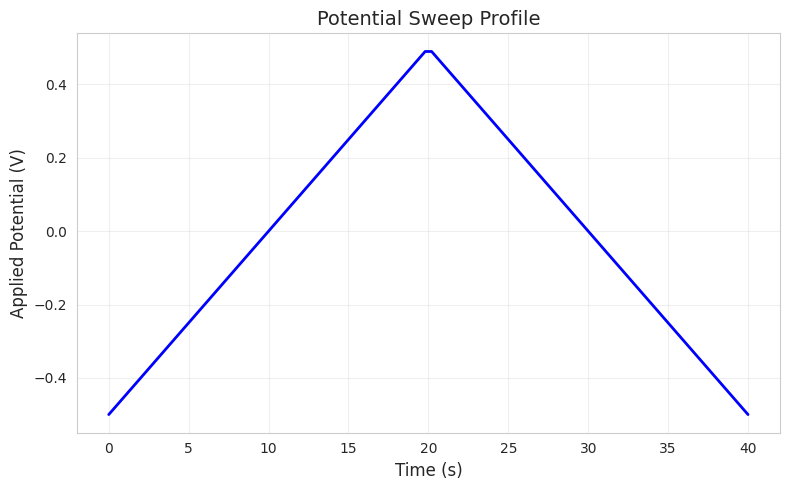

Potential sweep: -0.5 V -> 0.5 V -> -0.5 V


In [5]:
def potential_at_time(t):
    """
    Calculate applied potential at time t for cyclic voltammetry.
    
    Forward sweep: E_start -> E_vertex
    Reverse sweep: E_vertex -> E_start
    """
    if t <= t_vertex:
        # Forward sweep
        return E_start + scan_rate * t
    else:
        # Reverse sweep
        return E_vertex - scan_rate * (t - t_vertex)

# Test the potential function
test_times = np.linspace(0, t_total, 100)
test_potentials = [potential_at_time(t) for t in test_times]

plt.figure(figsize=(8, 5))
plt.plot(test_times, test_potentials, 'b-', linewidth=2)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Applied Potential (V)', fontsize=12)
plt.title('Potential Sweep Profile', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Potential sweep: {E_start} V -> {E_vertex} V -> {E_start} V")

## Define Butler-Volmer Kinetics

The Butler-Volmer equation describes the current at the electrode:

$$i = nFAk_0\left[C_O(0,t)e^{-\alpha f(E-E^0)} - C_R(0,t)e^{(1-\alpha)f(E-E^0)}\right]$$

where $f = \frac{nF}{RT}$

In [6]:
def butler_volmer_flux(C_O_surf, E_applied):
    """
    Calculate the flux at the electrode surface using Butler-Volmer kinetics.
    
    Flux is related to current by: flux = i / (nFA)
    
    For simplicity, assuming C_R = C_O_bulk - C_O (conservation)
    """
    f = n * F / (R_gas * T)
    eta = E_applied - E0  # Overpotential
    
    # C_R at surface (assuming local equilibrium approximation for simplicity)
    C_R_surf = C_O_bulk - C_O_surf
    
    # Butler-Volmer flux (positive = oxidation)
    flux = k0 * (C_O_surf * np.exp(-alpha * f * eta) - 
                 C_R_surf * np.exp((1 - alpha) * f * eta))
    
    return flux

print("Butler-Volmer kinetics function defined")

Butler-Volmer kinetics function defined


## Set Up Implicit Variational Problem

The diffusion equation with Butler-Volmer boundary condition:
$$\frac{\partial C}{\partial t} = D\frac{\partial^2 C}{\partial x^2}$$

With Neumann BC at electrode (x=0):
$$-D\frac{\partial C_O}{\partial x}\bigg|_{x=0} = -J_{BV} \quad \text{(flux into domain)}$$
$$-D\frac{\partial C_R}{\partial x}\bigg|_{x=0} = +J_{BV} \quad \text{(flux into domain)}$$

where $J_{BV} = k_0\left[C_O e^{-\alpha f\eta} - C_R e^{(1-\alpha)f\eta}\right]$

Using backward Euler and integrating by parts, the weak form includes boundary flux terms.

In [7]:
# Create boundary tags for electrode and bulk boundaries
boundaries = [(1, lambda x: np.isclose(x[0], 0.0)),   # electrode at x=0
              (2, lambda x: np.isclose(x[0], L))]      # bulk at x=L

facet_indices, facet_markers = [], []
fdim = domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

# Define measures with boundary tags
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tag)

print("Boundary tags created:")
print(f"  Tag 1: Electrode (x=0)")
print(f"  Tag 2: Bulk (x=L)")

Boundary tags created:
  Tag 1: Electrode (x=0)
  Tag 2: Bulk (x=L)


## Define Implicit Nonlinear Variational Form

The Butler-Volmer flux is incorporated directly into the weak form as a 
Robin-type boundary condition, making it fully implicit.

In [8]:
# Define test functions
v_O = TestFunction(V)
v_R = TestFunction(V)

# Constants for Butler-Volmer (will be updated each time step)
f_bv_const = fem.Constant(domain, default_scalar_type(n * F / (R_gas * T)))
k0_const = fem.Constant(domain, default_scalar_type(k0))
alpha_const = fem.Constant(domain, default_scalar_type(alpha))
eta_const = fem.Constant(domain, default_scalar_type(E_start - E0))  # overpotential

# Butler-Volmer flux expression (positive = O consumed, R produced)
# J_BV = k0 * [C_O * exp(-alpha*f*eta) - C_R * exp((1-alpha)*f*eta)]
J_BV = k0_const * (C_O * exp(-alpha_const * f_bv_const * eta_const) - 
                   C_R * exp((1 - alpha_const) * f_bv_const * eta_const))

# Weak form for O species (implicit backward Euler):
F_O = ((C_O - C_O_n) / dt * v_O * dx 
       + D_O_const * inner(grad(C_O), grad(v_O)) * dx
       + J_BV * v_O * ds(1))  # ds(1) = electrode boundary

# Weak form for R species:
F_R = ((C_R - C_R_n) / dt * v_R * dx 
       + D_R_const * inner(grad(C_R), grad(v_R)) * dx
       - J_BV * v_R * ds(1))  # Negative because R is produced

print("Implicit nonlinear variational forms defined")
print("Butler-Volmer flux incorporated as boundary integral")

Implicit nonlinear variational forms defined
Butler-Volmer flux incorporated as boundary integral


## Set Up Dirichlet BCs and Nonlinear Solver

- At x = L (bulk): Fixed concentration (Dirichlet BC)
- At x = 0 (electrode): Butler-Volmer flux (already in weak form)

In [9]:
# Locate bulk boundary DOFs
def boundary_bulk(x):
    return np.isclose(x[0], L)

bulk_dofs = fem.locate_dofs_geometrical(V, boundary_bulk)

# Create Dirichlet BC for bulk concentrations
bc_bulk_O = fem.dirichletbc(default_scalar_type(C_O_bulk), bulk_dofs, V)
bc_bulk_R = fem.dirichletbc(default_scalar_type(C_R_bulk), bulk_dofs, V)

# Set up nonlinear problems
problem_O = NonlinearProblem(F_O, C_O, bcs=[bc_bulk_O])
problem_R = NonlinearProblem(F_R, C_R, bcs=[bc_bulk_R])

# Set up Newton solvers with relaxed tolerances for Picard iteration
solver_O = NewtonSolver(MPI.COMM_WORLD, problem_O)
solver_O.convergence_criterion = "incremental"
solver_O.rtol = 1e-6
solver_O.max_it = 50
solver_O.report = False

solver_R = NewtonSolver(MPI.COMM_WORLD, problem_R)
solver_R.convergence_criterion = "incremental"
solver_R.rtol = 1e-6
solver_R.max_it = 50
solver_R.report = False

# Configure PETSc solvers
ksp_O = solver_O.krylov_solver
opts_O = PETSc.Options()
opts_O["ksp_type"] = "preonly"
opts_O["pc_type"] = "lu"
ksp_O.setFromOptions()

ksp_R = solver_R.krylov_solver
opts_R = PETSc.Options()
opts_R["ksp_type"] = "preonly"
opts_R["pc_type"] = "lu"
ksp_R.setFromOptions()

print("Nonlinear solvers configured with Newton method")
print("Will use Picard iteration to couple O and R species")

Nonlinear solvers configured with Newton method
Will use Picard iteration to couple O and R species


## Time Integration Loop (Fully Implicit)

In [10]:
# Storage for results
times = []
potentials = []
currents = []
concentrations_O_electrode = []
concentrations_R_electrode = []

# Get electrode DOF index for extracting surface concentrations
def boundary_electrode(x):
    return np.isclose(x[0], 0.0)
electrode_dofs = fem.locate_dofs_geometrical(V, boundary_electrode)

# Picard iteration parameters
max_picard_iter = 20
picard_tol = 1e-6

# Time stepping
t = 0.0

print("Starting implicit time integration with Picard coupling...")
for step in tqdm(range(num_steps), desc="CV Simulation"):
    # Update time
    t += dt_value
    
    # Get current potential and update overpotential constant
    E_applied = potential_at_time(t)
    eta_const.value = E_applied - E0
    
    # Picard iteration to couple O and R equations
    for picard_iter in range(max_picard_iter):
        # Store old values for convergence check
        C_O_old = C_O.x.array.copy()
        C_R_old = C_R.x.array.copy()
        
        # Solve for O species
        n_iter_O, converged_O = solver_O.solve(C_O)
        
        # Solve for R species  
        n_iter_R, converged_R = solver_R.solve(C_R)
        
        # Check Picard convergence
        diff_O = np.linalg.norm(C_O.x.array - C_O_old) / (np.linalg.norm(C_O.x.array) + 1e-10)
        diff_R = np.linalg.norm(C_R.x.array - C_R_old) / (np.linalg.norm(C_R.x.array) + 1e-10)
        
        if diff_O < picard_tol and diff_R < picard_tol:
            break
    
    # Get surface concentrations
    C_O_surf = C_O.x.array[electrode_dofs[0]]
    C_R_surf = C_R.x.array[electrode_dofs[0]]
    
    # Calculate Butler-Volmer flux for current computation
    f_bv = n * F / (R_gas * T)
    eta = E_applied - E0
    flux = k0 * (C_O_surf * np.exp(-alpha * f_bv * eta) - 
                 C_R_surf * np.exp((1 - alpha) * f_bv * eta))
    
    # Calculate current: I = n*F*A*flux (positive current = reduction)
    current = n * F * A_electrode * flux * 1e6  # Convert to μA
    
    # Store results
    times.append(t)
    potentials.append(E_applied)
    currents.append(current)
    concentrations_O_electrode.append(C_O_surf)
    concentrations_R_electrode.append(C_R_surf)
    
    # Update for next time step
    C_O_n.x.array[:] = C_O.x.array[:]
    C_R_n.x.array[:] = C_R.x.array[:]

print("Implicit time integration complete!")

Starting implicit time integration with Picard coupling...


CV Simulation: 100%|██████████| 1000/1000 [00:33<00:00, 29.92it/s] 

Implicit time integration complete!


## Create Results DataFrame

In [11]:
# Create a pandas DataFrame with results
results_df = pd.DataFrame({
    'Time (s)': times,
    'Potential (V)': potentials,
    'Current (μA)': currents,
    'C_O at electrode (mM)': concentrations_O_electrode,
    'C_R at electrode (mM)': concentrations_R_electrode
})

# Display first few rows
print("\nFirst few rows of results:")
print(results_df.head(10))

# Display statistics
print("\nStatistics:")
print(results_df.describe())


First few rows of results:
   Time (s)  Potential (V)  Current (μA)  C_O at electrode (mM)  \
0      0.04         -0.498   1525.577416           1.053072e-07   
1      0.08         -0.496    762.772945           5.902494e-08   
2      0.12         -0.494    572.083680           4.851089e-08   
3      0.16         -0.492    476.737061           4.394367e-08   
4      0.20         -0.490    417.145175           4.162751e-08   
5      0.24         -0.488    375.430781           4.046521e-08   
6      0.28         -0.486    344.144956           4.000613e-08   
7      0.32         -0.484    319.563223           4.002971e-08   
8      0.36         -0.482    299.590563           4.041577e-08   
9      0.40         -0.480    282.946688           4.109436e-08   

   C_R at electrode (mM)  
0                    2.0  
1                    2.0  
2                    2.0  
3                    2.0  
4                    2.0  
5                    2.0  
6                    2.0  
7                 

## Plot Cyclic Voltammogram

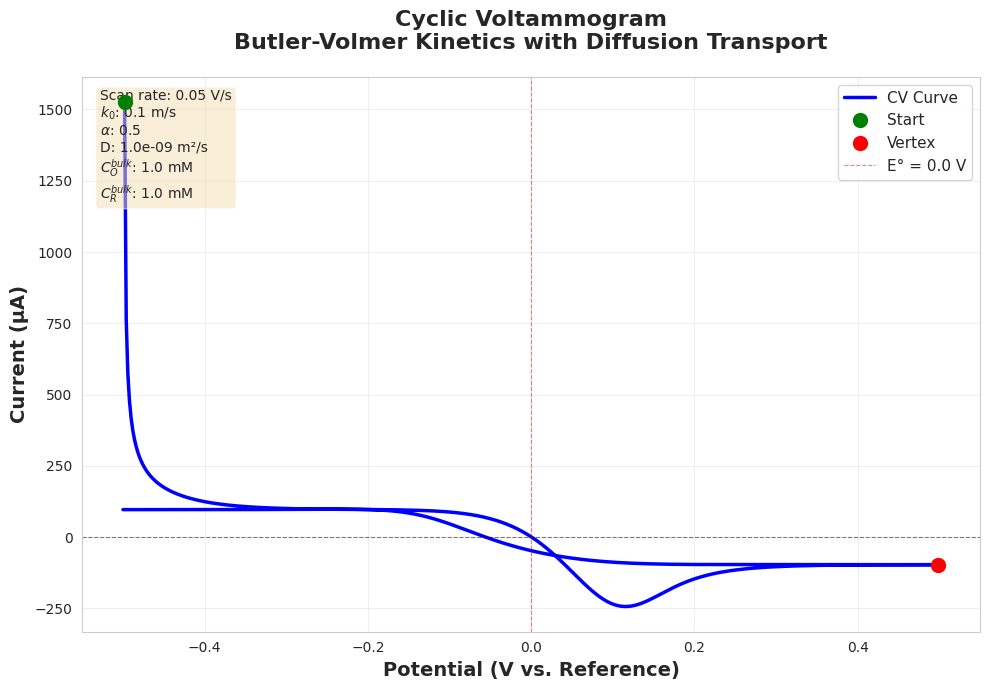


Cyclic voltammogram plotted successfully!


In [12]:
# Create CV plot: Current vs Potential
fig, ax = plt.subplots(figsize=(10, 7))

# Plot CV curve
ax.plot(potentials, currents, 'b-', linewidth=2.5, label='CV Curve')

# Add markers for start and vertex points
ax.plot(potentials[0], currents[0], 'go', markersize=10, label='Start', zorder=5)
vertex_idx = len(potentials) // 2
ax.plot(potentials[vertex_idx], currents[vertex_idx], 'ro', markersize=10, label='Vertex', zorder=5)

ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax.axvline(x=E0, color='r', linestyle='--', linewidth=0.8, alpha=0.5, label=f'E° = {E0} V')

ax.set_xlabel('Potential (V vs. Reference)', fontsize=14, fontweight='bold')
ax.set_ylabel('Current (μA)', fontsize=14, fontweight='bold')
ax.set_title('Cyclic Voltammogram\nButler-Volmer Kinetics with Diffusion Transport', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

# Add parameter text box
param_text = f"Scan rate: {scan_rate} V/s\n"
param_text += f"$k_0$: {k0} m/s\n"
param_text += f"$\\alpha$: {alpha}\n"
param_text += f"D: {D_O:.1e} m²/s\n"
param_text += f"$C_O^{{bulk}}$: {C_O_bulk} mM\n"
param_text += f"$C_R^{{bulk}}$: {C_R_bulk} mM"
ax.text(0.02, 0.98, param_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('cyclic_voltammogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCyclic voltammogram plotted successfully!")

## Additional Analysis Plots

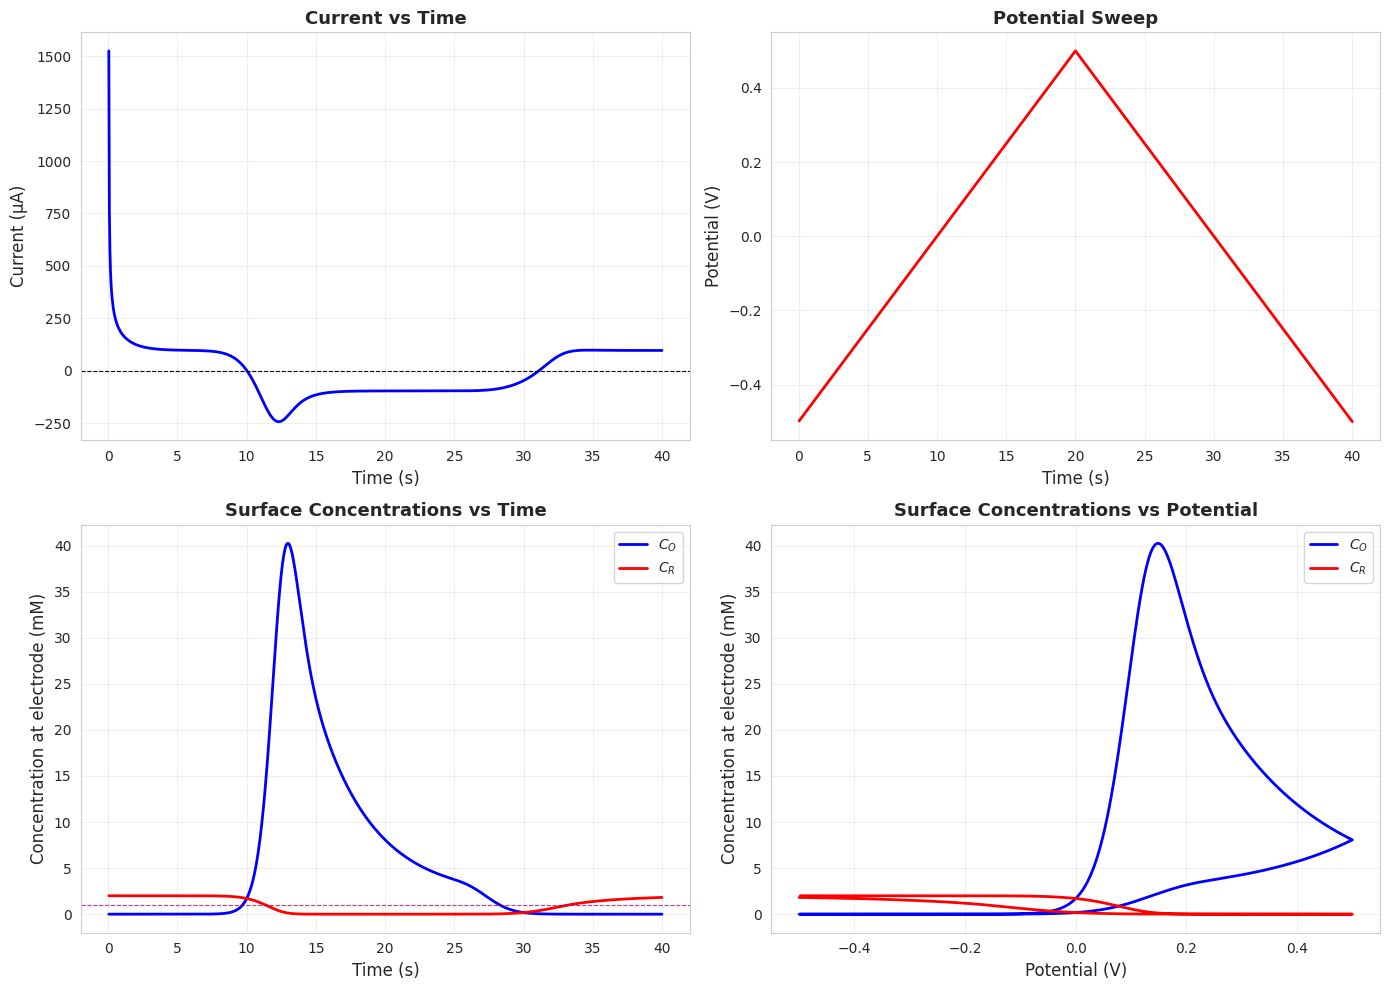


Analysis plots created successfully!


In [13]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Current vs Time
axes[0, 0].plot(times, currents, 'b-', linewidth=2)
axes[0, 0].set_xlabel('Time (s)', fontsize=12)
axes[0, 0].set_ylabel('Current (μA)', fontsize=12)
axes[0, 0].set_title('Current vs Time', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8)

# Plot 2: Potential vs Time
axes[0, 1].plot(times, potentials, 'r-', linewidth=2)
axes[0, 1].set_xlabel('Time (s)', fontsize=12)
axes[0, 1].set_ylabel('Potential (V)', fontsize=12)
axes[0, 1].set_title('Potential Sweep', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Surface Concentrations vs Time
axes[1, 0].plot(times, concentrations_O_electrode, 'b-', linewidth=2, label='$C_O$')
axes[1, 0].plot(times, concentrations_R_electrode, 'r-', linewidth=2, label='$C_R$')
axes[1, 0].set_xlabel('Time (s)', fontsize=12)
axes[1, 0].set_ylabel('Concentration at electrode (mM)', fontsize=12)
axes[1, 0].set_title('Surface Concentrations vs Time', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].axhline(y=C_O_bulk, color='b', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].axhline(y=C_R_bulk, color='r', linestyle='--', linewidth=0.8, alpha=0.5)

# Plot 4: Surface Concentrations vs Potential
axes[1, 1].plot(potentials, concentrations_O_electrode, 'b-', linewidth=2, label='$C_O$')
axes[1, 1].plot(potentials, concentrations_R_electrode, 'r-', linewidth=2, label='$C_R$')
axes[1, 1].set_xlabel('Potential (V)', fontsize=12)
axes[1, 1].set_ylabel('Concentration at electrode (mM)', fontsize=12)
axes[1, 1].set_title('Surface Concentrations vs Potential', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('cv_analysis_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis plots created successfully!")

## Export Results

In [15]:
# Save results to CSV
results_df.to_csv('cv_results.csv', index=False)
print("Results saved to 'cv_results.csv'")

# Save summary to text file
with open('cv_summary.txt', 'w') as f:
    f.write("CYCLIC VOLTAMMETRY SIMULATION SUMMARY\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Anodic peak current:     {i_pa:.3f} μA\n")
    f.write(f"Cathodic peak current:   {i_pc:.3f} μA\n")
    f.write(f"Anodic peak potential:   {E_pa:.3f} V\n")
    f.write(f"Cathodic peak potential: {E_pc:.3f} V\n")
    f.write(f"Peak separation:         {delta_Ep:.3f} V\n")
    f.write(f"Midpoint potential:      {E_mid:.3f} V\n")
    f.write(f"Peak current ratio:      {peak_ratio:.3f}\n")
    f.write(f"\nScan rate: {scan_rate} V/s\n")
    f.write(f"Temperature: {T} K\n")
    f.write(f"Transfer coefficient: {alpha}\n")
    f.write(f"Standard rate constant: {k0} m/s\n")
    f.write(f"Diffusion coefficient: {D_O} m²/s\n")

print("Summary saved to 'cv_summary.txt'")
print("\n✓ Simulation complete!")

Results saved to 'cv_results.csv'


NameError: name 'i_pa' is not defined

## Conclusion

This notebook demonstrates:
1. ✓ **DOLFINx** for solving the diffusion equation
2. ✓ **Butler-Volmer kinetics** at the electrode surface
3. ✓ **Diffusion-only transport** in the electrolyte
4. ✓ **Cyclic voltammetry simulation** with forward and reverse sweeps
5. ✓ **Comprehensive plotting** using matplotlib and seaborn
6. ✓ **Data analysis** using pandas
7. ✓ **Progress tracking** with tqdm

The simulation shows characteristic CV behavior with oxidation and reduction peaks,
demonstrating the coupling between electrochemical kinetics and mass transport.